# Chapter 6: Training Efficiency
Figures and exercises for Chapter 6 of [Sustainable AI](https://www.oreilly.com/library/view/sustainable-ai/9781098155506/) by Raghavendra Selvan.

**To run locally without errors, clone the entire repository:** 

``` git clone https://github.com/raghavian/sustainable_ai.git ```

## **Section: Training Costs of AI Models**
### **Figure 6-4.** Training costs for popular AI models based on the energy consumption reported. The carbon emissions CO2e are assuming the world average of 481gCO2e/kWh. For Llama-3 we assume the best reported PUE of 1.1.

(58.0, 22842)

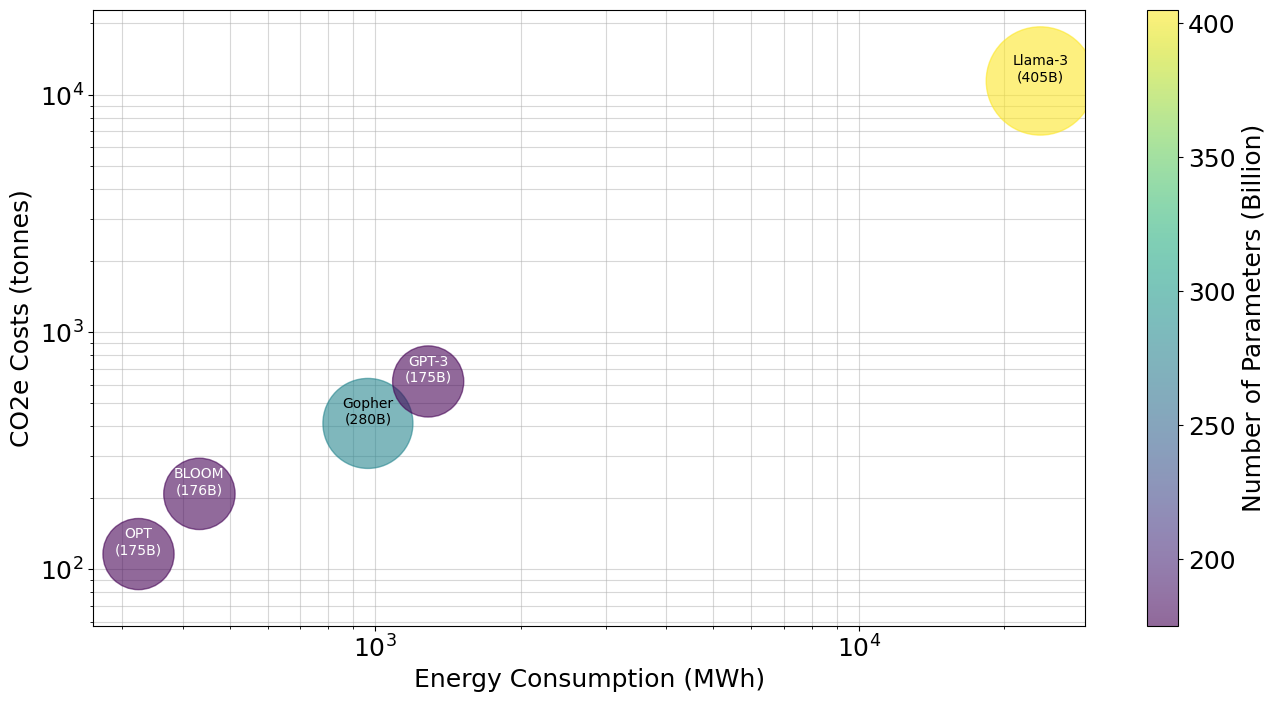

In [1]:
import matplotlib.pyplot as plt
import matplotlib

params = {'font.size': 18,
          'font.weight': 'normal',
          'axes.labelsize':18,
          'axes.titlesize':18,
          'axes.labelweight':'normal',
          'axes.titleweight':'normal',
          'legend.fontsize': 18,
         }
matplotlib.rcParams.update(params)

# Data from the table
models = ['Llama-3', 'Gopher', 'BLOOM', 'GPT-3', 'OPT']
parameters = [405e9, 280e9, 176e9, 175e9, 175e9]  # Number of parameters
energy_consumption = [23746, 966, 433, 1287, 324]  # Energy consumption in MWh
co2e_costs = [11421, 412, 208, 619, 116]  # CO2e costs in tonnes

# Convert parameters to a suitable marker size
marker_sizes = [param / 1e9 for param in parameters]

# Create scatter plot
fig, ax = plt.subplots(figsize=(16,8))
ax.set_axisbelow(True)
plt.grid(True, which="both", ls="-",alpha=0.5)
# Scatter points
sc = ax.scatter(energy_consumption, co2e_costs, s=[m*15 for m in marker_sizes], alpha=0.59, \
        c=marker_sizes, cmap='viridis', marker='o')

# Adding annotations
color = 'black'

for i, model in enumerate(models):
    annotation = f"{model}\n({parameters[i]/1e9:.0f}B)"
    if i > 1:
        color = 'white'

    ax.text(energy_consumption[i], co2e_costs[i], annotation, fontsize=10, ha='center',color=color)

# Adding color bar
cbar = plt.colorbar(sc)
cbar.set_label('Number of Parameters (Billion)')

# Set labels and title
plt.xlabel('Energy Consumption (MWh)')
plt.ylabel('CO2e Costs (tonnes)')
# Set log scale for both axes
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim([0.5*min(co2e_costs),2*max(co2e_costs)])

## **Section: Transfer Learning**

### **Example 6-1.** Use of pretrained models in PyTorch
In this example, we will look at the [PyTorch Image Models (timm)](https://timm.fast.ai), which hosts several hundred pretrained models.

#### Install timm package first.

In [ ]:
!pip install timm

In [1]:
# Import TIMM
import timm
from timm import models

# Load all model names available
model_names = models.list_models()
N = len(model_names)
print('Found %d models'%N)

# Load only pretrained models
pretrained = models.list_models(pretrained=True)
M = len(pretrained)
print('%d/%d models are pretrained'%(M,N))

# Load a Pretrained Vision Transformer
model = timm.create_model('vit_base_patch16_224', pretrained=True)

Found 1279 models
1689/1279 models are pretrained


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

### **Example 6-2.** Saving and loading models in PyTorch

In [6]:
import timm
import torch
### model class should be defined already
### Instantiate the model
model = timm.create_model('resnet18', pretrained=True)

### Save the state dict
torch.save(model.state_dict(), '../data/resnet18_state_dict.pth')

In [8]:

### Loading a saved model
# Instantiate the model and load the state dict
model = timm.create_model('resnet18', pretrained=False)
model.load_state_dict(torch.load('../data/resnet18_state_dict.pth'))
model.eval() # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

## **Section: Training Compressed Neural Networks**

### **Figure 6-5.** ResNet-50 weights at initialization (top) and at convergence (bottom).




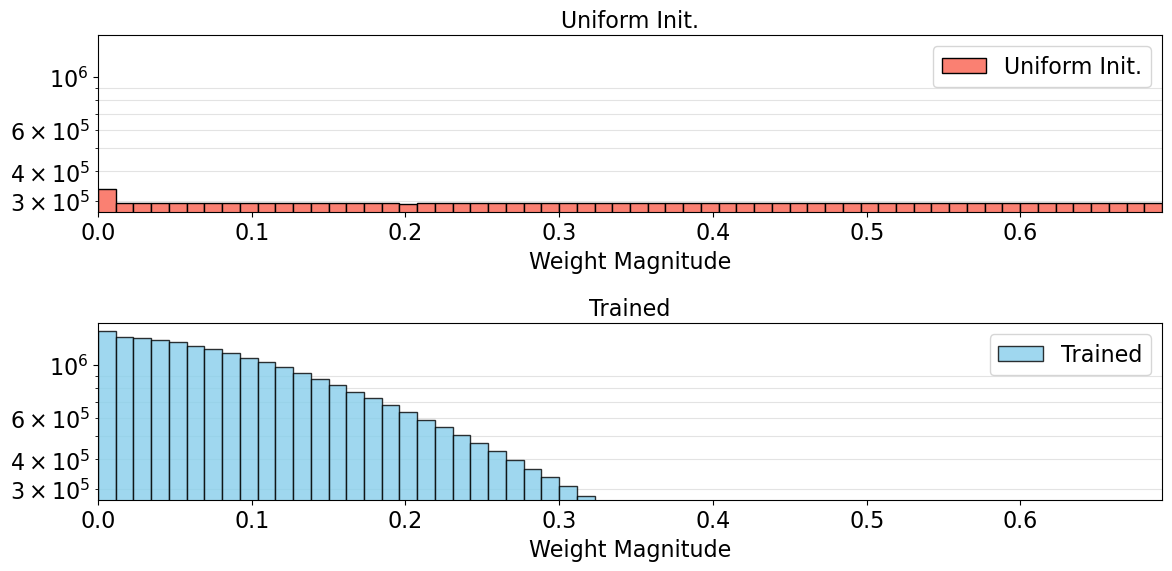

In [17]:
# Import necessary libraries
import timm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import matplotlib
params = {'font.size': 16,
          'font.weight': 'normal',
          'axes.labelsize':16,
          'axes.titlesize':16,
          'axes.labelweight':'normal',
          'axes.titleweight':'normal',
          'legend.fontsize': 16,
         }
matplotlib.rcParams.update(params)

# Load a pretrained model from timm (e.g., ResNet18)
pretrained_model = timm.create_model('resnet50', pretrained=True)

# Load the same model architecture without pretrained weights
untrained_model = timm.create_model('resnet50', pretrained=False)

# Apply He initialization to the untrained model
def initialize_weights_he(model):
    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            nn.init.uniform_(layer.weight)#, mode='fan_out', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

initialize_weights_he(untrained_model)

# Function to extract weight magnitudes from a model
def get_weight_magnitudes(model):
    all_weights = []
    for param in model.parameters():
        # Flatten the parameter and convert to numpy array
        all_weights.extend(param.detach().cpu().numpy().flatten())
    # Calculate and return magnitudes of the weights
    return np.abs(np.array(all_weights))

# Get magnitudes for pretrained and He-initialized untrained models
pretrained_magnitudes = get_weight_magnitudes(pretrained_model)
untrained_magnitudes = get_weight_magnitudes(untrained_model)

# Determine common x-axis limit
all_magnitudes = np.concatenate((pretrained_magnitudes, untrained_magnitudes))
xlim = (0,1*np.median(all_magnitudes)*3)
#untrained_magnitudes = np.concatenate((untrained_magnitudes,[np.max(all_magnitudes)]))

# Create subplots to compare the histograms
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharey=True)

axs[0].hist(untrained_magnitudes, bins=60, color='salmon', edgecolor='black', range=xlim, label='Uniform Init.')
axs[0].set_yscale('log')
axs[0].set_xlim(xlim)
axs[0].set_xlabel('Weight Magnitude')
axs[0].set_title('Uniform Init.')
axs[0].legend()
axs[0].set_axisbelow(True)
axs[0].grid(True, which="minor", ls="-", alpha=0.35)

axs[1].hist(pretrained_magnitudes, bins=60, color='skyblue', edgecolor='black', range=xlim, alpha=0.8, label='Trained')
axs[1].set_yscale('log')
axs[1].set_xlim(xlim)
axs[1].set_xlabel('Weight Magnitude')
axs[1].set_title('Trained')
axs[1].legend()
axs[1].set_axisbelow(True)
axs[1].grid(True, which="minor", ls="-", alpha=0.35)
plt.tight_layout()

### **Figure 6-7.** A full matrix of size 1,000 × 500 consists of 500,000 elements (dashed line). When the same matrix is factorized using lower rank matrices, the number of elements can be reduced drastically (dotted line). 

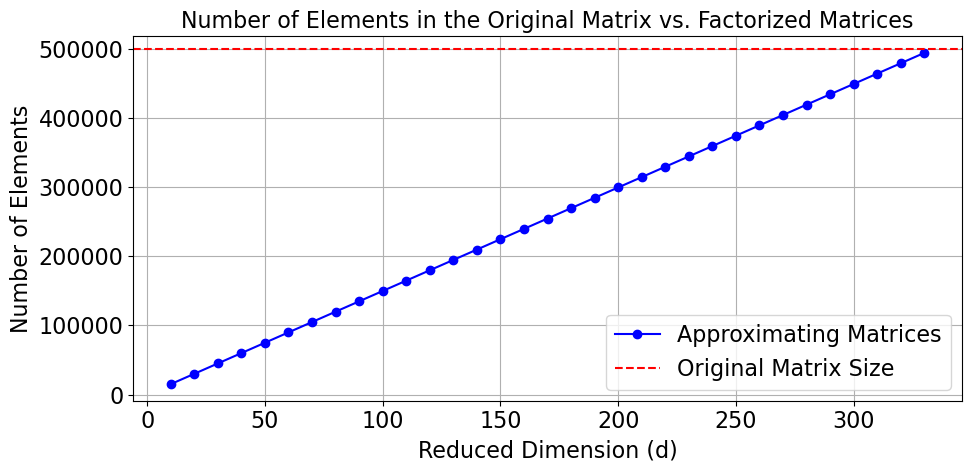

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

params = {'font.size': 16,
          'font.weight': 'normal',
          'axes.labelsize':16,
          'axes.titlesize':16,
          'axes.labelweight':'normal',
          'axes.titleweight':'normal',
          'legend.fontsize': 16,
         }
matplotlib.rcParams.update(params)

# Define the dimensions
N = 1000  # Number of rows
D = 500   # Original number of columns

# Range of approximating dimensions d
d_values = np.arange(10, 331, 10)  # d from 1 to 20
original_elements = N * D

# Calculate the number of elements in the approximating matrices for each d
approximating_elements = [(N * d + d * D) for d in d_values]

# Create a plot to visualize the decrease in the number of elements
plt.figure(figsize=(10, 5))
plt.plot(d_values, approximating_elements, marker='o', label='Approximating Matrices', color='blue')
plt.axhline(y=original_elements, color='red', linestyle='--', label='Original Matrix Size')

# Labeling the plot
plt.title('Number of Elements in the Original Matrix vs. Factorized Matrices')
plt.xlabel('Reduced Dimension (d)')
plt.ylabel('Number of Elements')
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()


### Low Rank Adaptation (LoRA)

Low-rank adaptation (LoRA) is a technique designed to fine-tune foundational models efficiently. Instead of updating all parameters of a pretrained model during the
fine-tuning process, LoRA introduces low-rank matrices that are added to the original weight matrices during the forward pass. This approach significantly reduces the
number of trainable parameters, resulting in faster fine-tuning with lower computational overhead.

<div>
<img src="../figures/suai_0608.png" width="600"/>
</div>

**PEFT:** Parameter-Efficient Fine-Tuning (PEFT) refers to a family of techniques designed to adapt large pretrained models -- language, vision, or multimodal -- without retraining or storing the full set of parameters. Instead of updating every weight in a multi-hundred-million-parameter model, PEFT methods introduce a small number of new, trainable parameters while keeping the pretrained weights frozen. The goal is to reduce memory footprint, speed up adaptation, and make fine-tuning feasible on modest hardware.

The [Hugging Face PEFT](https://huggingface.co/docs/peft/en/index) library standardizes these approaches across model types (Transformers, ViTs, diffusion models, etc.).

In [ ]:
### Start by installing peft library
!pip install peft

In [ ]:

import torch, torch.nn as nn
from torch.utils.data import DataLoader, Subset
import timm
from timm.data import resolve_model_data_config, create_transform
from peft import LoraConfig, get_peft_model
from sustainableai.datasets import AerialNIST

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- base model (timm ViT) ---
num_classes = 4
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
model = model.to(device)

# --- LoRA on timm ViT attention ---
# timm block attn has .qkv (fused) and .proj; we adapt both
lora_cfg = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["qkv", "proj"],   # names matched inside attention modules
    bias="none",
    modules_to_save=["head"],          # keep classifier trainable
)
model = get_peft_model(model, lora_cfg)
model.print_trainable_parameters()

base_ds = AerialNIST()
cfg = resolve_model_data_config(model)
tx = create_transform(**cfg)  # produces 3x224x224 with the right normalization

class Wrapped(torch.utils.data.Dataset):
    def __init__(self, ds, transform):
        self.ds, self.t = ds, transform
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x, y = self.ds[i]
        x = x.float()
        if x.max() > 1.0: x = x / 255.0
        return self.t(x), y

full = Wrapped(base_ds, tx)
g = torch.Generator().manual_seed(0)
perm = torch.randperm(len(full), generator=g).tolist()
train = Subset(full, perm[:20000])
val   = Subset(full, perm[40000:50000])
test  = Subset(full, perm[50000:60000])

train_loader = DataLoader(train, batch_size=128, shuffle=True,  num_workers=4, pin_memory=(device.type=="cuda"))
val_loader   = DataLoader(val,   batch_size=256, shuffle=False, num_workers=4, pin_memory=(device.type=="cuda"))
test_loader  = DataLoader(test,  batch_size=256, shuffle=False, num_workers=4, pin_memory=(device.type=="cuda"))

# --- training loop ---
opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
crit = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate(loader):
    model.eval()
    tot, correct, loss_sum = 0, 0, 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = crit(logits, yb)
        loss_sum += loss.item() * yb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        tot += yb.size(0)
    return loss_sum / tot, correct / tot

epochs = 1
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
for ep in range(1, epochs+1):
    model.train()
    run = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(xb)
            loss = crit(logits, yb)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        run += loss.item() * yb.size(0)
    val_loss, val_acc = evaluate(val_loader)
    print(f"epoch {ep:02d}  train {run/len(train):.4f}  val {val_loss:.4f}  acc {val_acc:.3%}")

test_loss, test_acc = evaluate(test_loader)
print(f"test  loss {test_loss:.4f}  acc {test_acc:.3%}")

# save just the adapters
model.save_pretrained("../data/timm_vit_lora_aerialnist_adapter")


trainable params: 912,388 || all params: 86,714,120 || trainable%: 1.0522


### **Example 6-3.** Half-precision training in PyTorch

**Note:** Half precision in PyTorch is only supported for GPU executions. You may encounter errors if trying on CPUs. Revert to full precision if running on CPUs.

In [ ]:
# basic notebook trainer for MLP, ViT, DenseNetSmall on a 40k 10k 10k split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.utils.data._utils.collate import default_collate

# import your models from models.py
from sustainableai.models import MLP, ViT, DenseNetSmall
from sustainableai.datasets import AerialNIST, collate_float_long, split_40k_10k_10k

# choose your dataset here; it must return (image, label)
ds = AerialNIST()  # example

# settings you probably want to tweak
model_name = "mlp"        # "mlp", "vit", "densenet"
epochs = 10
batch_size = 128
lr = 3e-4
seed = 0
num_workers = 4

def build_model(name: str) -> nn.Module:
    name = name.lower()
    if name == "mlp": return MLP()
    if name == "vit": return ViT()
    if name == "densenet": return DenseNetSmall()
    raise ValueError(f"unknown model {name}")

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    crit = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit(logits, y)
        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y.argmax(dim=1)).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

def train_model(model_name, ds, epochs=10, batch_size=128, lr=3e-4, seed=0, num_workers=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_model(model_name).to(device)
    # Cast the created model to half precision (FP16)
    print("Casting model and data to half precision")
    model = model.half() 
    train_ds, val_ds, test_ds = split_40k_10k_10k(ds, seed)

    train_loader = DataLoader(train_ds, shuffle=True,batch_size=batch_size)
    val_loader   = DataLoader(val_ds, shuffle=False,batch_size=batch_size)
    test_loader  = DataLoader(test_ds, shuffle=False,batch_size=batch_size)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    crit = nn.CrossEntropyLoss()

    best_state = None
    best_val = float("inf")

    for ep in range(1, epochs + 1):
        model.train()
        run_loss = 0.0
        
        for x, y in train_loader:
            # Cast the input data and labels into half precision
            x = x.half()
            y = y.half()
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = crit(logits, y)
            loss.backward()
            opt.step()
            run_loss += loss.item() * y.size(0)

        train_loss = run_loss / len(train_loader.dataset)
        val_loss, val_acc = evaluate(model, val_loader, device)
        print(f"epoch {ep:02d}  train {train_loss:.4f}  val {val_loss:.4f}  acc {val_acc:.3%}")

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    test_loss, test_acc = evaluate(model, test_loader, device)
    print(f"test  loss {test_loss:.4f}  acc {test_acc:.3%}")
    return model

# run training after you set ds
trained = train_model(model_name, ds, epochs=epochs, batch_size=batch_size, lr=lr, seed=seed, num_workers=num_workers)


### **Example 6-4.** Implementing AMP in PyTorch

As with half precision, automatic mixed precision is also useful only when using GPUs.

In [2]:
# basic notebook trainer for MLP, ViT, DenseNetSmall on a 40k 10k 10k split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.utils.data._utils.collate import default_collate

# import your models from models.py
from sustainableai.models import MLP, ViT, DenseNetSmall
from sustainableai.datasets import AerialNIST, collate_float_long, split_40k_10k_10k

# choose your dataset here; it must return (image, label)
ds = AerialNIST()  # example

# settings you probably want to tweak
model_name = "mlp"        # "mlp", "vit", "densenet"
epochs = 10
batch_size = 128
lr = 3e-4
seed = 0
num_workers = 4

def build_model(name: str) -> nn.Module:
    name = name.lower()
    if name == "mlp": return MLP()
    if name == "vit": return ViT()
    if name == "densenet": return DenseNetSmall()
    raise ValueError(f"unknown model {name}")

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    crit = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit(logits, y)
        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y.argmax(dim=1)).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

def train_model(model_name, ds, epochs=10, batch_size=128, lr=3e-4, seed=0, num_workers=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_model(model_name).to(device)
    
    train_ds, val_ds, test_ds = split_40k_10k_10k(ds, seed)
    # Creates once at the beginning of training
    scaler = torch.cuda.amp.GradScaler()
    train_loader = DataLoader(train_ds, shuffle=True,batch_size=batch_size)
    val_loader   = DataLoader(val_ds, shuffle=False,batch_size=batch_size)
    test_loader  = DataLoader(test_ds, shuffle=False,batch_size=batch_size)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    crit = nn.CrossEntropyLoss()

    best_state = None
    best_val = float("inf")

    for ep in range(1, epochs + 1):
        model.train()
        run_loss = 0.0
        
        for x, y in train_loader:
            # Cast the input data and labels into half precision
            
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            # Casts operations to mixed precision
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = crit(logits, y)
            # Scales the loss, and calls backward()
            # to create scaled gradients
            scaler.scale(loss).backward()

            # Unscales gradients and calls
            # or skips optimizer.step()
            scaler.step(opt)
            scaler.update()
            run_loss += loss.item() * y.size(0)

        train_loss = run_loss / len(train_loader.dataset)
        val_loss, val_acc = evaluate(model, val_loader, device)
        print(f"epoch {ep:02d}  train {train_loss:.4f}  val {val_loss:.4f}  acc {val_acc:.3%}")

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    test_loss, test_acc = evaluate(model, test_loader, device)
    print(f"test  loss {test_loss:.4f}  acc {test_acc:.3%}")
    return model

# run training after you set ds
trained = train_model(model_name, ds, epochs=epochs, batch_size=batch_size, lr=lr, seed=seed, num_workers=num_workers)


/home/raghav/miniconda3/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch 01  train 1.0618  val 0.9116  acc 57.840%
epoch 02  train 0.8457  val 0.8591  acc 62.420%
epoch 03  train 0.7973  val 0.7912  acc 67.110%
epoch 04  train 0.7689  val 0.8211  acc 62.610%
epoch 05  train 0.7476  val 0.7597  acc 66.270%
epoch 06  train 0.7293  val 0.7415  acc 67.850%
epoch 07  train 0.7219  val 0.7427  acc 66.360%
epoch 08  train 0.7019  val 0.6998  acc 70.210%
epoch 09  train 0.6881  val 0.7128  acc 71.430%
epoch 10  train 0.6737  val 0.6727  acc 71.970%
test  loss 0.6604  acc 72.510%


### **Example 6-5.** One-line code to use 8-bit optimizers like bitsandbytes

Install bitsandbytes package to use 8-bit optimizers.

In [3]:
### Install bitsandbytes
!pip install bitsandbytes

**Tip:** Change only the optimizer instantiation line in the cells above to try the 8-bit optimizer.

In [ ]:
import bitsandbytes as bnb
### Change the optimizer to BNB
# - optimizer = torch.optim.Adam(...)
opt = bnb.optim.Adam8bit(model.parameters(), lr=lr, weight_decay=0.01)